In [83]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

#Setting grid style
sns.set(style='white', palette='bright')

In [84]:
# Inputting data
ten_year = pd.read_csv(r'C:\Users\MADYMA\Desktop\Python Files\rates.csv')

# Doing a day over day change
hist_close = ten_year['FNMA 2.0']
hist_ret = hist_close / hist_close.shift(1) - 1.0     # shift 1 shifts forward one day; today has yesterday's price
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())

count    1252.000000
mean        0.004879
std         0.329309
min        -2.787774
25%        -0.161053
50%         0.003758
75%         0.164327
max         2.813058
Name: FNMA 2.0, dtype: float64


C:\Users\MADYMA\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


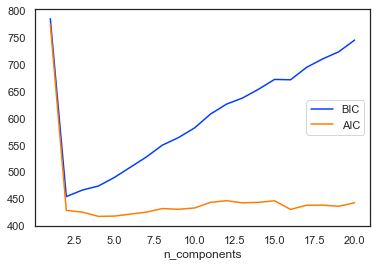

In [85]:
from sklearn.mixture import GaussianMixture

X = hist_ret.values.reshape(-1, 1) # reshape(-1) is a line vector, when reshape(-1,1) is a column

n_components = np.arange(1, 21) # np.arange allows you to define the stepsize and infers the number of steps(the number of values you get)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [86]:
# Here I choose 2 states
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
labels = gmm

In [87]:
# the result suggests first state is low vol, second state is high vol.
print(gmm.means_, gmm.covariances_) 

[[0.0053856 ]
 [0.00026587]] [[[0.05347678]]

 [[0.60830408]]]


In [88]:
gmm.predict_proba(X)

array([[0.46214531, 0.53785469],
       [0.60764172, 0.39235828],
       [0.86394973, 0.13605027],
       ...,
       [0.25233481, 0.74766519],
       [0.8133453 , 0.1866547 ],
       [0.96792292, 0.03207708]])

In [89]:
gmm_regimes = gmm.predict(X)

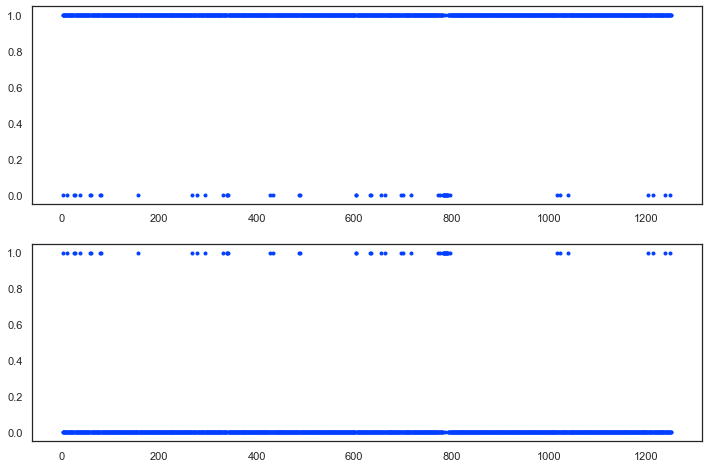

In [90]:
first_state = [1 if r == 0 else 0 for r in gmm_regimes]
second_state = [1 if r == 1 else 0 for r in gmm_regimes]
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(hist_ret.index, first_state, '.', label='first regime')
axes[1].plot(hist_ret.index, second_state, '.', label='second regime')
plt.show()

In [91]:
print(np.sum(first_state), np.sum(second_state), hist_ret.shape[0])

1202 50 1252


In [92]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [93]:
model = MarkovRegression(hist_ret, k_regimes=2, trend='nc', switching_variance=True)

C:\Users\MADYMA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [94]:
# result suggest first regime is low vol; second regime is high vol.
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:               FNMA 2.0   No. Observations:                 1252
Model:               MarkovRegression   Log Likelihood                -177.790
Date:                Fri, 21 Jan 2022   AIC                            363.580
Time:                        16:00:01   BIC                            384.110
Sample:                             0   HQIC                           371.297
                               - 1252                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0618      0.004     15.455      0.000       0.054       0.070
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9658      0.299      3.233      0.001       0.380       1.551
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9871      0.005    186.641      0.000       0.977       0.997
p[1->0]        0.2332      0.088      2.645      0.008       0.060       0.406
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

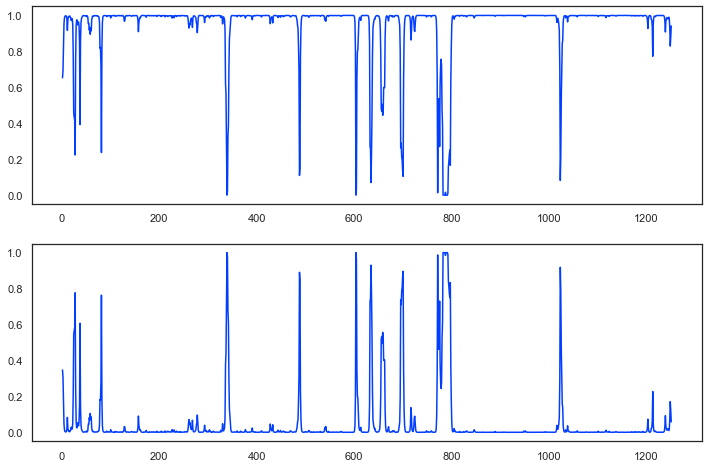

In [95]:
# Regime switch model has better results; which is expected.
# Gaussian mixture doesn't consider time sequence of historical returns.
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(res.smoothed_marginal_probabilities[0], label='first regime')
axes[1].plot(res.smoothed_marginal_probabilities[1], label='second regime')
plt.show()

In [96]:
print(np.sum(res.smoothed_marginal_probabilities[0] > 0.5), np.sum(res.smoothed_marginal_probabilities[1] > 0.5), hist_ret.shape[0])

1199 53 1252


In [97]:
# 1Y10Y Vol shadow
vol = pd.read_csv(r'C:\Users\MADYMA\Desktop\Python Files\vol.csv')

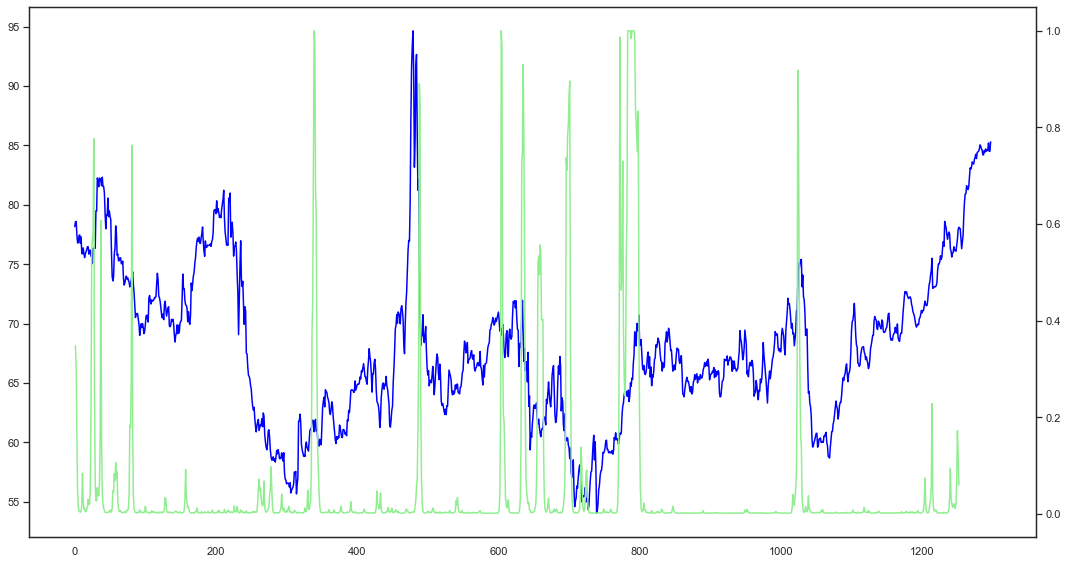

In [98]:
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(vol.PX_LAST, label='1Y10YR Vol', color='blue')
ax2 = ax1.twinx()
ax2.plot(res.smoothed_marginal_probabilities[1], label='second regime', color='lightgreen')
fig.tight_layout()
plt.show()